In [1]:
import sys
from os.path import join, exists, abspath
from os import getcwd
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'src')
sys.path.append(dname)
import rsatoolbox as rsa

In [8]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage

---

## FreeSurfer

In [9]:
dir_atlas = join(dir_git,'SeqSpatialSupp_fMRI/atlas/fs_LR_32k')

In [10]:
underlay = join(dir_atlas,'fs_LR.32k.LR.sulc.dscalar.gii')
border = join(dir_git,'surfAnalysisPy/standard_mesh/fs_L/fs_LR.32k.L.border')

In [11]:
def gifti_to_cmap(label_img):
    if isinstance(label_img, str):
        label_img = nb.load(label_img)
    if not isinstance(label_img, nb.gifti.gifti.GiftiImage):
        raise TypeError("Expected 'gifti' file")

    labels = label_img.labeltable.labels
    rgba = np.zeros((len(labels),4))
    for i,label in enumerate(labels):
        rgba[i,] = labels[i].rgba
    
    cmap = colors.ListedColormap(rgba, N=len(rgba))

    return cmap

In [12]:
def cmap_to_cbar(cmap, list_label):
    # 0~11 값이 각각 구간 중앙에 오도록 boundaries 설정
    N = cmap.N
    norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, N, 1), ncolors=N)
    
    # colorbar만 따로 그리기
    fig, ax = plt.subplots(figsize=(8, 1))
    fig.subplots_adjust(bottom=0.5)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # 더미 mappable
    
    cbar = fig.colorbar(sm, cax=ax, orientation='horizontal', ticks=np.arange(N))
    
    # 라벨을 변경
    if N == len(list_label)+1:
        labels = np.concatenate((['0'],list_label))
    elif N == len(list_label):
        labels = list_label
    else:
        labels = 0
    cbar.ax.set_xticklabels(labels)
    
    plt.show()

1. ROI: general

In [13]:
list_roi = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

9 [0 1 2 3 4 5 6 7 8]


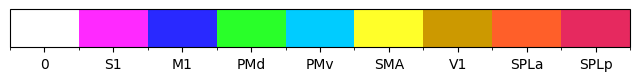

In [14]:
data = nb.load(join(dir_atlas,'ROI.32k.L.label.gii'))
tmp = np.unique(data.darrays[0].data)
print(len(tmp), tmp)

cmap = gifti_to_cmap(data)
cmap_to_cbar(cmap, list_roi)

<Axes: >

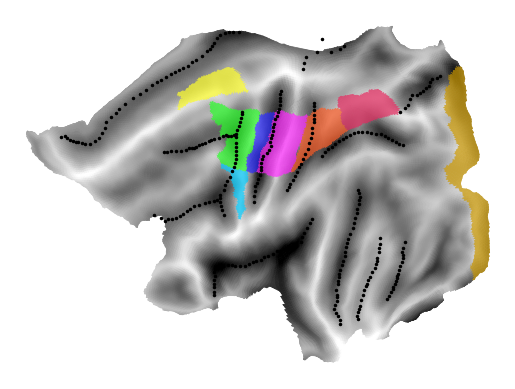

In [15]:
fig, ax = plt.subplots()

plt.sca(ax)
surf.plot.plotmap(
    data=data,
    surf='fs32k_L',
    underlay=underlay, alpha=0.7, cmap=cmap, colorbar=False,
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)

---

# Letter vs. Spatial

In [16]:
dir_surf = su.get_dir_surf()
hemi = 'L'

In [17]:
glm = 1
dir_work = join(dir_surf,'glm_%d'%glm)

In [24]:
subj = 'S01'
reginfo = su.get_reginfo(subj=subj,glm=glm)
reginfo

,sn,run,cond,regIdx,seq,cue,reg
0,1,1,1,1,1,L,"(1,L)"
1,1,1,2,2,1,S,"(1,S)"
2,1,1,3,3,2,L,"(2,L)"
3,1,1,4,4,2,S,"(2,S)"
4,1,1,5,5,3,L,"(3,L)"
...,...,...,...,...,...,...,...
59,1,8,4,60,2,S,"(2,S)"
60,1,8,5,61,3,L,"(3,L)"
61,1,8,6,62,3,S,"(3,S)"
62,1,8,7,63,4,L,"(4,L)"


In [33]:
reginfo.reg.unique()

array(['(1,L)', '(1,S)', '(2,L)', '(2,S)', '(3,L)', '(3,S)', '(4,L)',
       '(4,S)'], dtype=object)

In [67]:
fnames = glob(join(dir_work,'S*.%s.glm_%d.con.func.gii'%(hemi,glm)))
fnames

['/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/S01.L.glm_1.con.func.gii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/S02.L.glm_1.con.func.gii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/S03.L.glm_1.con.func.gii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/S05.L.glm_1.con.func.gii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/S06.L.glm_1.con.func.gii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/S08.L.glm_1.con.func.gii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/S09.L.glm_1.con.func.gii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/S10.L.glm_1.con.func.gii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/S11.L.glm_1.con.func.gii']

In [68]:
contrasts = []
for fname in fnames:
    gii = nb.load(fname)
    tmp = []
    for darray in gii.darrays:
        tmp.append(darray.data)
    contrasts.append(tmp)
contrasts = np.array(contrasts)
# shape = (# of subjects, # of regressors, # of verteces)
contrasts.shape

(9, 8, 32492)

In [69]:
cues = np.array(['L' if 'L' in reg else 'S' for reg in reginfo.reg.unique()])
cues

array(['L', 'S', 'L', 'S', 'L', 'S', 'L', 'S'], dtype='<U1')

In [70]:
con_L = np.mean(contrasts[:,cues=='L',:], axis=(0,1))
con_S = np.mean(contrasts[:,cues=='S',:], axis=(0,1))

<Axes: >

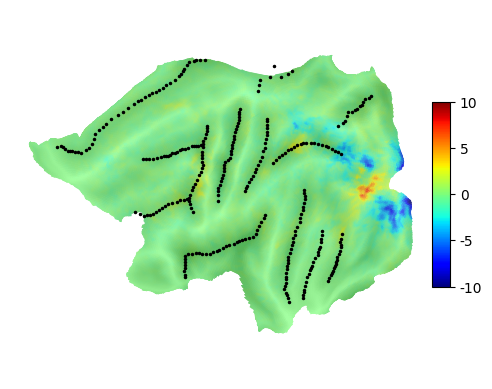

In [71]:
surf.plot.plotmap(
    data=con_L-con_S,
    surf='fs32k_L',
    underlay=underlay, alpha=0.7,
    cmap=cm.jet, colorbar=True, cscale=[-10,10],
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)

---